In [15]:
import numpy as np
import pandas as pd
import math
import urllib
import s2sphere as s2

from matplotlib import colors as mcolors
from matplotlib.path import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns

from shapely import affinity
from shapely.geometry import mapping, shape
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.io.img_tiles import OSM
import cartopy.io.img_tiles as cimgt

import utm
import json

from bs4 import BeautifulSoup
import progressbar

%matplotlib inline

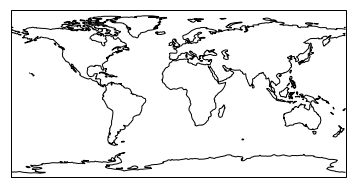

In [16]:
### Testing to ensure cartopy is working fine (there are some issues on OS X depending on version) 

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.show()

In [17]:
### Some constants

# list of state abbreviations
states = ['AL','AK','AZ','AR','CA','CO','CT','DC','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

# headers for csv export
data = [['state_abbr', 'county_name', 'party', 'votes_total']]

# each page has a summary table that rolls up results at the state level
# get rid of it
def cond(x):
    if x:
        return x.startswith("table ec-table") and not "table ec-table ec-table-summary" in x
    else:
        return False

In [18]:
### Pulling 2016 election results of counties for each state

hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}


pb = progressbar.ProgressBar(max_value=len(states))
for i, state in enumerate(states):
    url = 'http://townhall.com/election/2016/president/' + state + '/county'
    req = urllib.request.Request(url, headers=hdr)
    with urllib.request.urlopen(req) as response:
        r = response.read()
    soup = BeautifulSoup(r, 'html.parser')
    # loop through each <table> tag with .ec-table class
    tables = soup.findAll('table', attrs={'class':cond})

    for table in tables:
        if table.findParent("table") is None:
            table_body = table.find('tbody')

            rows = table_body.find_all('tr')
            for row in rows:
                cols = row.find_all('td')
                # first tbody tr has four td
                if len(cols) == 4:
                    # strip text from each td
                    divs = cols[0].find_all('div')
                    county = divs[0].text.strip()
                    party = cols[1]['class'][0]
                    total_votes = int(cols[2].text.strip().replace(',','').replace('-','0'))
                # all other tbody tr have three td
                else:
                    party = cols[1]['class'][0]
                    total_votes = int(cols[1].text.strip().replace(',','').replace('-','0'))
                    
                #combine each row's results
                rowData = [state,county,party,total_votes]
                data.append(rowData)
    pb.update(i+1)
    pb.finish()
   

100% (51 of 51) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (51 of 51) |########################| Elapsed Time: 0:00:36 Time:  0:00:36

In [19]:
### Setting the column names for the townhall data
townhall = pd.DataFrame(data)
new_header = townhall.iloc[0]
townhall = townhall[1:]
townhall.columns = new_header
print(townhall.shape[0])
townhall.head()

14188


,state_abbr,county_name,party,votes_total
1,AL,Autauga,GOP,18110
2,AL,Autauga,DEM,5908
3,AL,Autauga,IND,538
4,AL,Autauga,IND,105
5,AL,Baldwin,GOP,72780


In [20]:
### Let's look at a Alaska ...

townhall[(townhall['state_abbr'] == 'AK')]

,state_abbr,county_name,party,votes_total
269,AK,Alaska,GOP,130415
270,AK,Alaska,DEM,93007
271,AK,Alaska,LIB,14593
272,AK,Alaska,GRN,4445
273,AK,Alaska,OTH,4128


In [21]:
### ... and Carson City in Nevada

print(townhall[(townhall['state_abbr'] == 'NV') & (townhall['county_name'] == 'Carson City')])

0    state_abbr  county_name party votes_total
7943         NV  Carson City   GOP       13125
7944         NV  Carson City   DEM        9610
7945         NV  Carson City   LIB        1159
7946         NV  Carson City   OTH        1122


In [22]:
### Need to adjust some formatting with specific counties, for example District of Columbia (DC)

townhall.loc[townhall['state_abbr'] == 'DC', 'county_name'] = 'District of Columbia'
townhall.loc[townhall['county_name'] == 'Sainte Genevieve', 'county_name'] = 'Ste. Genevieve County'
townhall.loc[townhall['county_name'] == 'Oglala Lakota', 'county_name'] = 'Oglala'
print(townhall[(townhall['county_name'] == 'District of Columbia') | (townhall['county_name'] == 'Ste. Genevieve County') | (townhall['county_name'] == 'Oglala')])

co_names = townhall['county_name'].unique()
[print(co_names[i]) for i, x in enumerate(co_names) if "Co." in x]
print(townhall[(townhall['state_abbr'] == 'NV') & (townhall['county_name'] == 'Carson City')])

# change 'Co.' to 'County' in county_name to match census county name
townhall['county_name'] = townhall['county_name'].apply(lambda x: x.replace('Co.','County').strip())

0     state_abbr            county_name party votes_total
1415          DC   District of Columbia   DEM      260223
1416          DC   District of Columbia   GOP       11553
1417          DC   District of Columbia   LIB        4501
1418          DC   District of Columbia   DCG        3995
7227          MO  Ste. Genevieve County   GOP        5495
7228          MO  Ste. Genevieve County   DEM        2540
7229          MO  Ste. Genevieve County   LIB         323
7230          MO  Ste. Genevieve County   GRN          55
7231          MO  Ste. Genevieve County   OTH          46
10780         SD                 Oglala   DEM        2504
10781         SD                 Oglala   GOP         241
10782         SD                 Oglala   LIB         104
10783         SD                 Oglala   OTH          47


In [ ]:
### Combining the county name and state name, this is useful later when we merge data sets

townhall['combined'] = townhall['state_abbr'] + townhall['county_name'].apply(lambda x: x.replace(' ','').lower())
print(townhall[(townhall['state_abbr'] == 'NV') & (townhall['county_name'] == 'Carson City')])

In [24]:
# Getting county FIPS information. This is a two-digit state code and a three-digit county code
# FIPS [https://en.wikipedia.org/wiki/FIPS_county_code]
# 
# county_fips data from https://www.census.gov/geo/reference/codes/cou.html
census = pd.read_csv('http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt',sep=',',header=None, dtype=str)
census.columns = ['state_abbr', 'state_fips', 'county_fips', 'county_name', 'fips_class_code']
print(census.shape)
census.head()

In [ ]:
# Again, looking at Alaska, this time with state & county FIPS and class codes

ak_counties = census[(census['state_abbr'] == 'AK')].shape[0]
print(ak_counties)
census[(census['state_abbr'] == 'AK')]

In [207]:
# veiw special cases
print(census[(census['state_abbr'] == 'NV') & (census['county_name'] == 'Carson City')])

     state_abbr state_fips county_fips  county_name fips_class_code  \
1763         NV         32         510  Carson City              C7   

          combined  
1763  NVcarsoncity  


In [ ]:
# Let's see the C7 class
census[(census['fips_class_code'] == 'C7')]

In [ ]:
# change Shannon County, SD to Oglala County, SD
# http://rapidcityjournal.com/news/local/it-s-official-oglala-lakota-county-replaces-shannon-county-name/article_ac5c2369-3fea-5f94-9898-b007b7ddf22c.html
# townhall.loc[townhall['county_name'] == 'Sainte Genevieve', 'county_name'] = 'Ste. Genevieve County'
census.loc[(census['county_name'] == 'Shannon County') & (census['state_abbr'] == 'SD'), 'county_name'] = 'Oglala County'
census[(census['state_abbr'] == 'SD')]

In [ ]:
# state of Alaska reports results at the precinct and state level; no county level data available
# report results as the states level; 
# ugly fix to get townhall results and census counties to work together
# future plan: roll up precinct-level results to the county level
census.loc[(census['state_abbr'] == 'AK'),'county_name'] = 'Alaska'

In [ ]:
# change county_name values in townhall data to match 'county_name' values for C7 fips class code cities
# get and transform C7 city names
cities = (census['state_abbr'][(census['fips_class_code'] == 'C7')] + census['county_name'][(census['fips_class_code'] == 'C7')].apply(lambda x: x.replace('city','').replace(' ','').lower()))
cities

In [31]:
# loop through 'combined' column and compare to cities series to add 'city' to H1 fips class code to townhall data
for i, row in cities.iteritems():
    if row != 'NVcarsoncity':
        townhall.loc[townhall['combined'] == row, 'combined'] = row + 'city'
    
print(townhall[(townhall['combined'] == 'NVcarsoncity')])

In [ ]:
# remove 'county' from 'combined' column of C7 fips class code counties in townhall
townhall['combined'] = townhall['combined'].str.replace('county','')
print(townhall[(townhall['county_name'] == 'Oglala')])

In [35]:
census['combined'] = census['state_abbr'] + census['county_name'].apply(lambda x: x.replace('County','').replace('Parish','').replace(' ','').lower())
print(census[(census['state_abbr'] == 'NV') & (census['county_name'] == 'Carson City')])
# print(census[(census['state_abbr'] == 'VA') & (census['county_name'] == 'Bedford County')])


     state_abbr state_fips county_fips  county_name fips_class_code  \
1763         NV         32         510  Carson City              C7   

          combined  
1763  NVcarsoncity  


In [36]:
# return sum of votes by state and county
townhall['total_votes'] = townhall['votes_total'].groupby(townhall['combined']).transform('sum')
townhall_counties = townhall.drop('votes_total',axis=1)

# view dataset by selected state
print(townhall_counties[(townhall_counties['state_abbr'] == 'NV') & (townhall_counties['county_name'] == 'Carson City')])

0    state_abbr  county_name party      combined  total_votes
7943         NV  Carson City   GOP  NVcarsoncity        25016
7944         NV  Carson City   DEM  NVcarsoncity        25016
7945         NV  Carson City   LIB  NVcarsoncity        25016
7946         NV  Carson City   OTH  NVcarsoncity        25016


In [37]:
# join census and townhall data on the 'combined' column
right = townhall.set_index('combined')
left = census.set_index('combined')

In [38]:
combined = left.join(right, lsuffix='', rsuffix='_r')
combined = combined.reset_index()
print('Joined dataset has ' + str(combined.shape[0]) + ' items')

Joined dataset has 14422 items


In [39]:
# view data by selected state
combined[(combined['state_abbr'] == 'NV') & (combined['fips_class_code'] == 'C7')]

,combined,state_abbr,state_fips,county_fips,county_name,fips_class_code,state_abbr_r,county_name_r,party,votes_total,total_votes
8968,NVcarsoncity,NV,32,510,Carson City,C7,NV,Carson City,GOP,13125,25016.0
8969,NVcarsoncity,NV,32,510,Carson City,C7,NV,Carson City,DEM,9610,25016.0
8970,NVcarsoncity,NV,32,510,Carson City,C7,NV,Carson City,LIB,1159,25016.0
8971,NVcarsoncity,NV,32,510,Carson City,C7,NV,Carson City,OTH,1122,25016.0


In [40]:
# scale Alaska by number of counties
combined.loc[(combined['state_abbr'] == 'AK'),'votes_total'] = (combined['votes_total'][combined['state_abbr'] == 'AK']/ak_counties).astype(int)
combined[combined['state_abbr'] == 'AK']

,combined,state_abbr,state_fips,county_fips,county_name,fips_class_code,state_abbr_r,county_name_r,party,votes_total,total_votes
0,AKalaska,AK,02,013,Alaska,H1,AK,Alaska,GOP,4497,246588.0
1,AKalaska,AK,02,013,Alaska,H1,AK,Alaska,DEM,3207,246588.0
2,AKalaska,AK,02,013,Alaska,H1,AK,Alaska,LIB,503,246588.0
3,AKalaska,AK,02,013,Alaska,H1,AK,Alaska,GRN,153,246588.0
4,AKalaska,AK,02,013,Alaska,H1,AK,Alaska,OTH,142,246588.0
5,AKalaska,AK,02,016,Alaska,H5,AK,Alaska,GOP,4497,246588.0
6,AKalaska,AK,02,016,Alaska,H5,AK,Alaska,DEM,3207,246588.0
7,AKalaska,AK,02,016,Alaska,H5,AK,Alaska,LIB,503,246588.0
8,AKalaska,AK,02,016,Alaska,H5,AK,Alaska,GRN,153,246588.0
9,AKalaska,AK,02,016,Alaska,H5,AK,Alaska,OTH,142,246588.0


In [41]:
county_level_combined = combined.drop_duplicates()
print('Combined dataset has ' + str(county_level_combined.shape[0]) + ' total items (comared to {})'.format(combined.shape[0]))

Combined dataset has 14421 total items (comared to 14422)


In [42]:
# return only D and R results
county_level_combined = county_level_combined[(county_level_combined['party'] == 'GOP') | (county_level_combined['party'] == 'DEM')]
print('Filtered dataset has ' + str(county_level_combined.shape[0]) + ' D and R items')


Filtered dataset has 6282 D and R items


In [43]:
# flatten dataset by adding votes by R and D columns
county_level_combined['votes_dem'] = county_level_combined['votes_total'].where(county_level_combined['party'] == 'DEM',0).astype('float32')
county_level_combined['votes_gop'] = county_level_combined['votes_total'].where(county_level_combined['party'] == 'GOP',0).astype('float32')

In [44]:
# drop party and party-level totals and other columns
county_level_combined.drop(['party','votes_total','state_abbr_r','county_name_r'], axis=1, inplace=True)
# total_results = county_level_combined.drop(['party','votes_total','fips_class_code','state_abbr_r','county_name_r', 'votes_dem', 'votes_gop'], axis=1, inplace=True)
county_level_combined[(county_level_combined['state_abbr'] == 'NV') & (county_level_combined['fips_class_code'] == 'C7')]

,combined,state_abbr,state_fips,county_fips,county_name,fips_class_code,total_votes,votes_dem,votes_gop
8968,NVcarsoncity,NV,32,510,Carson City,C7,25016.0,0.0,13125.0
8969,NVcarsoncity,NV,32,510,Carson City,C7,25016.0,9610.0,0.0


In [45]:
# pivot data to consolidate
party_pivot = pd.pivot_table(county_level_combined,index=["combined"],values=["votes_dem","votes_gop"],aggfunc=np.sum)
total_pivot = pd.pivot_table(county_level_combined,index=["combined"],values=["total_votes"],aggfunc=np.mean)

In [46]:
party_pivot.head()

,votes_dem,votes_gop
combined,,
AKalaska,93003.0,130413.0
ALautauga,5908.0,18110.0
ALbaldwin,18409.0,72780.0
ALbarbour,4848.0,5431.0
ALbibb,1874.0,6733.0


In [47]:
total_pivot.head()

,total_votes
combined,
AKalaska,246588.0
ALautauga,24661.0
ALbaldwin,94090.0
ALbarbour,10390.0
ALbibb,8748.0


In [48]:
# join party and total pivots
combined_pivot = party_pivot.join(total_pivot, lsuffix='', rsuffix='_r')
print('Joined dataset has ' + str(combined_pivot.shape[0]) + ' items')
combined_pivot

Joined dataset has 3113 items


,votes_dem,votes_gop,total_votes
combined,,,
AKalaska,93003.0,130413.0,246588.0
ALautauga,5908.0,18110.0,24661.0
ALbaldwin,18409.0,72780.0,94090.0
ALbarbour,4848.0,5431.0,10390.0
ALbibb,1874.0,6733.0,8748.0
ALblount,2150.0,22808.0,25384.0
ALbullock,3530.0,1139.0,4701.0
ALbutler,3716.0,4891.0,8685.0
ALcalhoun,13197.0,32803.0,47376.0


In [49]:
# add percentages for each R and D of total votes
# calculate percentage of total vote per major candidates
combined_pivot['per_dem'] = combined_pivot['votes_dem'] / combined_pivot['total_votes']
combined_pivot['per_gop'] = combined_pivot['votes_gop'] / combined_pivot['total_votes']
combined_pivot['diff'] = abs(combined_pivot['votes_gop'] - combined_pivot['votes_dem']).map('{:,.0f}'.format)
combined_pivot['per_point_diff'] = abs(combined_pivot['per_dem'] - combined_pivot['per_gop']).map('{:,.2%}'.format)

In [50]:
combined_pivot.head()

,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff
combined,,,,,,,
AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%
ALautauga,5908.0,18110.0,24661.0,0.239569,0.734358,"12,202",49.48%
ALbaldwin,18409.0,72780.0,94090.0,0.195653,0.773515,"54,371",57.79%
ALbarbour,4848.0,5431.0,10390.0,0.466603,0.522714,583,5.61%
ALbibb,1874.0,6733.0,8748.0,0.214220,0.769662,"4,859",55.54%


In [51]:
# join pivotted and unpivotted data
right = census.set_index('combined')
# left = combined_pivot.set_index('combined')

In [52]:
right.head()

,state_abbr,state_fips,county_fips,county_name,fips_class_code
combined,,,,,
ALautauga,AL,01,001,Autauga County,H1
ALbaldwin,AL,01,003,Baldwin County,H1
ALbarbour,AL,01,005,Barbour County,H1
ALbibb,AL,01,007,Bibb County,H1
ALblount,AL,01,009,Blount County,H1


In [53]:
county_level_final = combined_pivot.join(right, lsuffix='', rsuffix='_r')
county_level_final = county_level_final.reset_index()
print('Joined dataset has ' + str(county_level_final.shape[0]) + ' items')
county_level_final

Joined dataset has 3141 items


,combined,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,state_fips,county_fips,county_name,fips_class_code
0,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,013,Alaska,H1
1,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,016,Alaska,H5
2,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,020,Alaska,H6
3,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,050,Alaska,H5
4,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,060,Alaska,H1
5,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,068,Alaska,H1
6,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,070,Alaska,H5
7,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,090,Alaska,H1
8,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,100,Alaska,H1
9,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,105,Alaska,H5


In [54]:
# create FIPS columns for visualizations
county_level_final['combined_fips'] = county_level_final['state_fips'].apply(lambda x: x.lstrip('0')) + county_level_final['county_fips']
county_level_final

,combined,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,state_fips,county_fips,county_name,fips_class_code,combined_fips
0,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,013,Alaska,H1,2013
1,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,016,Alaska,H5,2016
2,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,020,Alaska,H6,2020
3,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,050,Alaska,H5,2050
4,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,060,Alaska,H1,2060
5,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,068,Alaska,H1,2068
6,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,070,Alaska,H5,2070
7,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,090,Alaska,H1,2090
8,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,100,Alaska,H1,2100
9,AKalaska,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,02,105,Alaska,H5,2105


In [55]:
# drop irrelevant columns
county_level_final = county_level_final.drop(['combined','county_fips','state_fips','fips_class_code'], axis=1)
print('Final dataset has ' + str(county_level_final.shape[0]) + ' items')
county_level_final

Final dataset has 3141 items


,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips
0,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2013
1,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2016
2,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2020
3,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2050
4,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2060
5,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2068
6,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2070
7,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2090
8,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2100
9,93003.0,130413.0,246588.0,0.377159,0.528870,"37,410",15.17%,AK,Alaska,2105


In [56]:
# view data by selected state
county_level_final[(county_level_final['state_abbr'] == 'AK')]

,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips
0,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2013
1,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2016
2,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2020
3,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2050
4,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2060
5,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2068
6,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2070
7,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2090
8,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2100
9,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2105


In [58]:
# Saving the county level data set
county_level_final.to_csv('data/US_voting/2016_US_County_Level_Presidential_Results.csv',sep=',')

In [208]:
# Loading the shapely files for the US counties
# https://nationalmap.gov/small_scale/atlasftp.html?openChapters=chpbound#chpbound
reader = shpreader.Reader('data/US_voting/county_shapes/countyl010g.shp')

counties = list(reader.geometries())
countries = list(reader.records())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

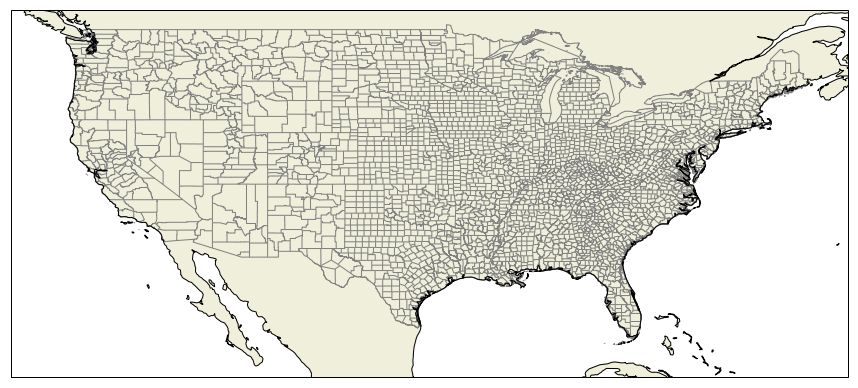

In [209]:
# Plot the map of US counties
plt.figure(figsize=(15, 9))
ax = plt.axes(projection=ccrs.PlateCarree())

lllon = -129
urlon = -64
lllat = 22.0
urlat = 50.5
# and calculate a centerpoint, needed for the projection:
centerlon = float(lllon + urlon) / 2.0
centerlat = float(lllat + urlat) / 2.0


ax.set_extent([lllon, urlon, lllat, urlat], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND.with_scale('50m'))
# ax.add_feature(cfeature.OCEAN.with_scale('50m'))
# ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
ax.coastlines('50m')

In [62]:
# Visualising the contiguous United States
# http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_20m.zip
reader = shpreader.Reader('data/US_voting/cb_2016_us_county_20m/cb_2016_us_county_20m.shp')
records = list(reader.records())

In [210]:
# We can generate a color palette based on the number of records (counties) we have
cols = sns.color_palette('BuGn_r', n_colors=len(records))

In [ ]:
# Because Hawaii and Alaska are outside the scope of visualization, we can move them into their own section
# so we will need to know which FIPS belong to each
hawaii_fips = county_level_final[(county_level_final['state_abbr'] == 'HI')]['combined_fips'].values
alaska_fips = county_level_final[(county_level_final['state_abbr'] == 'AK')]['combined_fips'].values

In [402]:
# Create a key-value pair of the column names and their meanings because there are too many to memorize and they are too short to make sense of

keys = \
"""SPREAD_BINARIZED SPREAD per_gop per_dem SUMLEV STATE COUNTY STNAME CTYNAME YEAR AGEGRP TOT_POP TOT_MALE TOT_FEMALE WA_MALE WA_FEMALE BA_MALE BA_FEMALE IA_MALE IA_FEMALE AA_MALE AA_FEMALE NA_MALE NA_FEMALE TOM_MALE TOM_FEMALE WAC_MALE WAC_FEMALE BAC_MALE BAC_FEMALE IAC_MALE IAC_FEMALE AAC_MALE AAC_FEMALE NAC_MALE NAC_FEMALE NH_MALE NH_FEMALE NHWA_MALE NHWA_FEMALE NHBA_MALE NHBA_FEMALE NHIA_MALE NHIA_FEMALE NHAA_MALE NHAA_FEMALE NHNA_MALE NHNA_FEMALE NHTOM_MALE NHTOM_FEMALE NHWAC_MALE NHWAC_FEMALE NHBAC_MALE NHBAC_FEMALE NHIAC_MALE NHIAC_FEMALE NHAAC_MALE NHAAC_FEMALE NHNAC_MALE NHNAC_FEMALE H_MALE H_FEMALE HWA_MALE HWA_FEMALE HBA_MALE HBA_FEMALE HIA_MALE HIA_FEMALE HAA_MALE HAA_FEMALE HNA_MALE HNA_FEMALE HTOM_MALE HTOM_FEMALE HWAC_MALE HWAC_FEMALE HBAC_MALE HBAC_FEMALE HIAC_MALE HIAC_FEMALE HAAC_MALE HAAC_FEMALE HNAC_MALE HNAC_FEMALE POP_DENSITY"""

vals = \
"""Voting Result Difference (Binary)
Voting Result Difference
Democrat
GOP
Geographic Summary Level
State FIPS code
County FIPS code
State Name
County Name
Year
Age group
Total population
Total male population
Total female population
White alone male population
White alone female population
Black or African American alone male population
Black or African American alone female population
American Indian and Alaska Native alone male population 
American Indian and Alaska Native alone female population 
Asian alone male population
Asian alone female population
Native Hawaiian and Other Pacific Islander alone male population 
Native Hawaiian and Other Pacific Islander alone female population
Two or More Races male population
Two or More Races female population
White alone or in combination male population
White alone or in combination female population
Black or African American alone or in combination male population
Black or African American alone or in combination female population
American Indian and Alaska Native alone or in combination male population
American Indian and Alaska Native alone or in combination female population
Asian alone or in combination male population
Asian alone or in combination female population
Native Hawaiian and Other Pacific Islander alone or in combination male population
Native Hawaiian and Other Pacific Islander alone or in combination female population
Not Hispanic male population
Not Hispanic female population
Not Hispanic, White alone male population
Not Hispanic, White alone female population
Not Hispanic, Black or African American alone male population 
Not Hispanic, Black or African American alone female population 
Not Hispanic, American Indian and Alaska Native alone male population
Not Hispanic, American Indian and Alaska Native alone female population
Not Hispanic, Asian alone male population
Not Hispanic, Asian alone female population
Not Hispanic, Native Hawaiian and Other Pacific Islander alone male population
Not Hispanic, Native Hawaiian and Other Pacific Islander alone female population
Not Hispanic, Two or More Races male population
Not Hispanic, Two or More Races female population
Not Hispanic, White alone or in combination male population
Not Hispanic, White alone or in combination female population
Not Hispanic, Black or African American alone or in combination male population
Not Hispanic, Black or African American alone or in combination female population
Not Hispanic, American Indian and Alaska Native alone or in combination male population
Not Hispanic, American Indian and Alaska Native alone or in combination female population
Not Hispanic, Asian alone or in combination male population
Not Hispanic, Asian alone or in combination female population
Not Hispanic, Native Hawaiian and Other Pacific Islander alone or in combination male population
Not Hispanic, Native Hawaiian and Other Pacific Islander alone or in combination female population
Hispanic male population
Hispanic female population
Hispanic, White alone male population
Hispanic, White alone female population
Hispanic, Black or African American alone male population 
Hispanic, Black or African American alone female population
Hispanic, American Indian and Alaska Native alone male population
Hispanic, American Indian and Alaska Native alone female population
Hispanic, Asian alone male population
Hispanic, Asian alone female population
Hispanic, Native Hawaiian and Other Pacific Islander alone male population
Hispanic, Native Hawaiian and Other Pacific Islander alone female population
Hispanic, Two or More Races male population
Hispanic, Two or More Races female population
Hispanic, White alone or in combination male population
Hispanic, White alone or in combination female population 
Hispanic, Black or African American alone or in combination male population
Hispanic, Black or African American alone or in combination female population
Hispanic, American Indian and Alaska Native alone or in combination male population
Hispanic, American Indian and Alaska Native alone or in combination female population
Hispanic, Asian alone or in combination male population
Hispanic, Asian alone or in combination female population 
Hispanic, Native Hawaiian and Other Pacific Islander alone or in combination male population
Hispanic, Native Hawaiian and Other Pacific Islander alone or in combination female population
County Population Density"""

keys = keys.split(" ")
vals = vals.split("\n")
assert len(keys)==len(vals)
total_legend = len(keys)
legend = {}
for i in range(total_legend):
    legend[keys[i]] = vals[i]

In [512]:
# Helper functions

def get_county_fips(record) -> str:
    """ Given a record, extract the state and county FIPS and return them combined. 
        The data frame excludes the leading 0 so we drop it.
    """
    combined_fp = record.attributes['STATEFP'] + record.attributes['COUNTYFP']
    if combined_fp[0]=='0':
        combined_fp = combined_fp[1:]
    return combined_fp

def get_hi_ak_geom(records):
    """ Given a record, if it is in Alaska or Hawaii, return its geometry"""
    hi_ak_geoms = {'HI': [], 'AK': []}
    for i, record in enumerate(records):
        combined_fp = get_county_fips(record)
        if combined_fp in hawaii_fips:
            hi_ak_geoms['HI'].append(record.geometry)
        elif combined_fp in alaska_fips:
            hi_ak_geoms['AK'].append(record.geometry)
    return hi_ak_geoms

def get_county_pop_density(record, df) -> float:
    """ Given a record, compute the population density by dividing the total population 
        (from the data frame) by the land area (coverted from m^2 to km^2)
    """
    combined_fp = get_county_fips(record)
    land_area = record.attributes['ALAND']/(1000.0*1000.0)
    pop = df[(df['combined_fips'] == combined_fp)]['TOT_POP']
    return pop/land_area

def get_color_fraction(df, combined_fp, key) -> float:
    try:            
        color_fract = df[(df['combined_fips'] == combined_fp)][key].values[0]
    except AttributeError as ae:
        color_fract = df[(df['combined_fips'] == combined_fp)][key]
    except Exception as e:
        try:
            color_fract = df.loc[combined_fp][key].values[0]
        except AttributeError as ae:
            color_fract = df.loc[combined_fp][key]
        except KeyError as ke:
            color_fract = 0.0
    return color_fract

def get_county_voting_color(record, df, **kwargs) -> list:
    """ Given a record and the parameters of interest, compute the corresponding color with which
        to fill the county. 
        
        Args
            - df: input data frame
            - **kwargs: keywords (i.e. column names) of the input dataframe. Default is percentage of
                GOP and DEM votes
    """
    combined_fp = get_county_fips(record)
    
    if 'divisor' in kwargs:
        divisor = df.loc[combined_fp][kwargs['divisor']] if (isinstance(kwargs['divisor'], str) and combined_fp in plot_df.index) else kwargs['divisor'] if (isinstance(kwargs['divisor'], (int, float))) else 1.0
    else:
        divisor = 1.0
    blue = get_color_fraction(df, combined_fp, kwargs['scale1'])/divisor if 'scale1' in kwargs else 0.0        
    red = get_color_fraction(df, combined_fp, kwargs['scale2'])/divisor if 'scale2' in kwargs else 0.0
    return [red, 0, blue]


def plot_heatmaps_by_count(df, records, **kwargs):
    """Given a dataframe, plot color-coded results on the map of the US
    
        Args:
            - df: input data frame
            - records: list of Cartopy shapely records
            - *args: keywords (i.e. column names) of the input dataframe. Default is percentage of
                     GOP and DEM votes
    """
    if not kwargs or not ('scale1' in kwargs or 'scale2' in kwargs):
        kwargs['scale1'] = 'per_dem'
        kwargs['scale2'] = 'per_gop'
    if not kwargs or 'figsize' not in kwargs:
        kwargs['figsize'] = (20,14)
    if not kwargs or 'save' not in kwargs:
        kwargs['save'] = False
    if not kwargs or 'legend' not in kwargs:
        kwargs['legend'] = False
    if not kwargs or 'color' not in kwargs:
        kwargs['color'] = False
        
    # A smaller subplot to contain Alaska and Hawaii
    fig = plt.figure(figsize=kwargs['figsize'])
    gs = gridspec.GridSpec(nrows=3, ncols=3)
    ax = []
    ax.append(plt.subplot(gs[1, :1], projection=ccrs.PlateCarree()))
    ax.append(plt.subplot(gs[:, 1:], projection=ccrs.PlateCarree()))

    # Set the lat/lon range around the continental US
    lllon = -126
    urlon = -65
    lllat = 24.0
    urlat = 50.5
    # and somewhere in the ocean where we re-center Alaska and Hawaii
    hi_ak = [-159, -112, 22, 45]

    ax[1].set_extent([lllon, urlon, lllat, urlat], crs=ccrs.PlateCarree())
    ax[0].set_extent(hi_ak, crs=ccrs.PlateCarree())

    ax[1].add_feature(cfeature.LAND.with_scale('50m'))
    ax[1].coastlines('50m')

    # Iterate through the records
    for i, record in enumerate(records):
        

        county_col = get_county_voting_color(record, df, **kwargs)
        if kwargs['color'] and isinstance(kwargs['color'], (str, list)):
            if np.all(county_col==[0,0,0]):
                county_col = "#004B8D"
            else:
                county_col = kwargs['color']
        geometry = record.geometry
        combined_fp = get_county_fips(record)
        if geometry in hi_ak_geoms['HI']:    
            geom = affinity.translate(geom=geometry, xoff=30, yoff=5)
            ax[0].add_geometries([geom], ccrs.PlateCarree(), facecolor=county_col, edgecolor='k', 
                          lw=0.5, zorder=5)
        elif geometry in hi_ak_geoms['AK']:    
            geom = affinity.translate(geom=geometry, xoff=16, yoff=-30)
            ax[0].add_geometries([geom], ccrs.PlateCarree(), facecolor=county_col, edgecolor='k', 
                          lw=0.5, zorder=5)
        else:
            ax[1].add_geometries([geometry], ccrs.PlateCarree(),
                          facecolor=county_col, edgecolor='k', 
                          lw=0.5, zorder=5)

    if kwargs['legend']:
        
        cmap = plt.cm.RdBu_r
        norm = mcolors.Normalize(vmin=0, vmax=1)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbaxes = inset_axes(ax[1], 
                            width="3%", 
                            height="30%", 
                            loc=3,
                            bbox_to_anchor=(0.01, 0.01, 1, 1),
                            bbox_transform=ax[1].transAxes,
                            borderpad=0,
                           ) 
        cbar = plt.colorbar(cax=cbaxes, mappable=sm, orientation='vertical')
        cbar.ax.get_yaxis().set_ticks([])
        
        legend_lbls = []
        if 'scale1' in kwargs:
            legend_lbls.extend([legend[kwargs['scale1']]])
        if 'scale2' in kwargs:
            legend_lbls.extend([legend[kwargs['scale2']]])
        legend_pos = 1.5
        if len(legend_lbls)>1:            
            for j, lab in enumerate(legend_lbls):
                cbar.ax.text(legend_pos, (1+10*j)/12, lab, ha='left', va='center')
        elif len(legend_lbls)==1:
            cbar.ax.text(legend_pos, -0.2, '0% ', ha='left', va='center')
            cbar.ax.text(legend_pos, 0.5, legend_lbls[0], ha='left', va='center')
            cbar.ax.text(legend_pos, 1.2, '100% ', ha='left', va='center')
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel('', rotation=270)

    if kwargs['save']:
        fname = kwargs['save'] if isinstance(kwargs['save'], str) else "output"
        fname += ".png" if "." not in fname else ""
        plt.savefig('figures/US_voting_' + fname)
    
    plt.show()

In [ ]:
# Get the geometries for counties in Alaska and Hawaii
hi_ak_geoms = get_hi_ak_geom(records=records)

In [76]:
# Population and Housing Unit Estimates
# https://www2.census.gov/programs-surveys/popest/datasets/2010-2017/counties/asrh/
population_df = pd.read_csv('data/US_voting/cc-est2017-alldata.csv', encoding = "ISO-8859-1")


# Need to add the FIPS codes on which we join with the voting data
population_df['combined_fips'] = population_df['STATE'].apply(lambda x: str(x).lstrip('0')) + population_df['COUNTY'].apply(lambda x: '00'+str(x) if len(str(x))==1 else '0'+str(x) if len(str(x))==2 else str(x))
population_df.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
0,50,1,1,Alabama,Autauga County,1,0,54571,26569,28002,...,607,538,57,48,26,32,9,11,19,10
1,50,1,1,Alabama,Autauga County,1,1,3579,1866,1713,...,77,56,9,5,4,1,0,0,2,1
2,50,1,1,Alabama,Autauga County,1,2,3991,2001,1990,...,64,66,2,3,2,7,2,3,2,0
3,50,1,1,Alabama,Autauga County,1,3,4290,2171,2119,...,51,57,13,7,5,5,2,1,1,1
4,50,1,1,Alabama,Autauga County,1,4,4290,2213,2077,...,48,44,7,5,0,2,2,1,3,1


In [ ]:
# Here is the join, county-level voting and population
# Note that we are only interested in the year 2016 (election year) but we are using population of all age groups
right = county_level_final.set_index('combined_fips')
left = population_df.loc[(population_df['YEAR']==9) & (population_df['AGEGRP']==0)].set_index('combined_fips')
population_and_vote_df = left.join(right, lsuffix='', rsuffix='_r')
population_and_vote_df = population_and_vote_df.reset_index()
print('Joined dataset has ' + str(population_and_vote_df.shape[0]) + ' items')

In [ ]:
# Let's go ahead and compute the population density using a small helper function

def pop_density(row):
    """Take a row from the dataframe and return the population density based on the land area and total population"""
    return row['TOT_POP']/fip_to_land_area[row['combined_fips']]

fip_to_land_area = {}
for i, record in enumerate(records):
    land_area = record.attributes['ALAND']/(1000.0*1000.0)
    fip_to_land_area[get_county_fips(record)] = land_area

population_and_vote_df['POP_DENSITY'] = population_and_vote_df.apply(pop_density, axis=1)
population_and_vote_df['POP_DENSITY'].describe()

In [214]:
# We can melt the dataframe
value_vars = ['TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE',
       'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE',
       'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE',
       'WAC_MALE', 'WAC_FEMALE', 'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE',
       'IAC_FEMALE', 'AAC_MALE', 'AAC_FEMALE', 'NAC_MALE', 'NAC_FEMALE',
       'NH_MALE', 'NH_FEMALE', 'NHWA_MALE', 'NHWA_FEMALE', 'NHBA_MALE',
       'NHBA_FEMALE', 'NHIA_MALE', 'NHIA_FEMALE', 'NHAA_MALE', 'NHAA_FEMALE',
       'NHNA_MALE', 'NHNA_FEMALE', 'NHTOM_MALE', 'NHTOM_FEMALE', 'NHWAC_MALE',
       'NHWAC_FEMALE', 'NHBAC_MALE', 'NHBAC_FEMALE', 'NHIAC_MALE',
       'NHIAC_FEMALE', 'NHAAC_MALE', 'NHAAC_FEMALE', 'NHNAC_MALE',
       'NHNAC_FEMALE', 'H_MALE', 'H_FEMALE', 'HWA_MALE', 'HWA_FEMALE',
       'HBA_MALE', 'HBA_FEMALE', 'HIA_MALE', 'HIA_FEMALE', 'HAA_MALE',
       'HAA_FEMALE', 'HNA_MALE', 'HNA_FEMALE', 'HTOM_MALE', 'HTOM_FEMALE',
       'HWAC_MALE', 'HWAC_FEMALE', 'HBAC_MALE', 'HBAC_FEMALE', 'HIAC_MALE',
       'HIAC_FEMALE', 'HAAC_MALE', 'HAAC_FEMALE', 'HNAC_MALE', 'HNAC_FEMALE']
id_vars = ['combined_fips',
 'SUMLEV',
 'STATE',
 'COUNTY',
 'STNAME',
 'CTYNAME',
#  'YEAR',
#  'AGEGRP',
 'votes_dem',
 'votes_gop',
 'total_votes',
 'per_dem',
 'per_gop',
 'diff',
 'per_point_diff',
 'state_abbr',
 'county_name']

population_and_vote_melt_df = pd.melt(population_and_vote_df, id_vars=id_vars, value_vars=value_vars)
print(population_and_vote_melt_df.columns)
population_and_vote_melt_df.head()

Index(['combined_fips', 'SUMLEV', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'votes_dem', 'votes_gop', 'total_votes', 'per_dem', 'per_gop', 'diff',
       'per_point_diff', 'state_abbr', 'county_name', 'variable', 'value'],
      dtype='object')


,combined_fips,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,variable,value
0,1001,50,1,1,Alabama,Autauga County,5908.0,18110.0,24661.0,0.239569,0.734358,"12,202",49.48%,AL,Autauga County,TOT_POP,55278
1,1003,50,1,3,Alabama,Baldwin County,18409.0,72780.0,94090.0,0.195653,0.773515,"54,371",57.79%,AL,Baldwin County,TOT_POP,207509
2,1005,50,1,5,Alabama,Barbour County,4848.0,5431.0,10390.0,0.466603,0.522714,583,5.61%,AL,Barbour County,TOT_POP,25774
3,1007,50,1,7,Alabama,Bibb County,1874.0,6733.0,8748.0,0.214220,0.769662,"4,859",55.54%,AL,Bibb County,TOT_POP,22633
4,1009,50,1,9,Alabama,Blount County,2150.0,22808.0,25384.0,0.084699,0.898519,"20,658",81.38%,AL,Blount County,TOT_POP,57562


In [ ]:
# Saving the dataframes
population_and_vote_df.to_csv('data/US_voting/population_and_vote.csv')
population_and_vote_melt_df.to_csv('data/US_voting/population_and_vote_melt.csv')

In [85]:
# Let's combine all the subpopulations by gender so we can look at various
# racial/ethnic groups in total as well as by gender
genders = {"_FEMALE":"Female","_MALE":"Male", "":"Both", "_POP":"Both"}

def get_var_and_gender(var):
    return [genders[''.join(var.partition("_")[1:])], ''.join(var.partition("_")[0])]

pb = progressbar.ProgressBar(max_value=len(value_vars))
pb.start()
for i, var in enumerate(value_vars):
    vals = get_var_and_gender(var)
    locs = population_and_vote_melt_df.index.values[population_and_vote_melt_df['variable']==var]
    population_and_vote_melt_df.loc[locs]['Gender'] = vals[0]
    population_and_vote_melt_df.loc[locs]['Var'] = vals[1]
    pb.update(i+1)
pb.finish()

100% (73 of 73) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [285]:
print(population_and_vote_melt_df.columns)
population_and_vote_melt_df.head()

Index(['combined_fips', 'SUMLEV', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'votes_dem', 'votes_gop', 'total_votes', 'per_dem', 'per_gop', 'diff',
       'per_point_diff', 'state_abbr', 'county_name', 'variable', 'value'],
      dtype='object')


,combined_fips,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,variable,value
0,1001,50,1,1,Alabama,Autauga County,5908.0,18110.0,24661.0,0.239569,0.734358,"12,202",49.48%,AL,Autauga County,TOT_POP,55278
1,1003,50,1,3,Alabama,Baldwin County,18409.0,72780.0,94090.0,0.195653,0.773515,"54,371",57.79%,AL,Baldwin County,TOT_POP,207509
2,1005,50,1,5,Alabama,Barbour County,4848.0,5431.0,10390.0,0.466603,0.522714,583,5.61%,AL,Barbour County,TOT_POP,25774
3,1007,50,1,7,Alabama,Bibb County,1874.0,6733.0,8748.0,0.214220,0.769662,"4,859",55.54%,AL,Bibb County,TOT_POP,22633
4,1009,50,1,9,Alabama,Blount County,2150.0,22808.0,25384.0,0.084699,0.898519,"20,658",81.38%,AL,Blount County,TOT_POP,57562


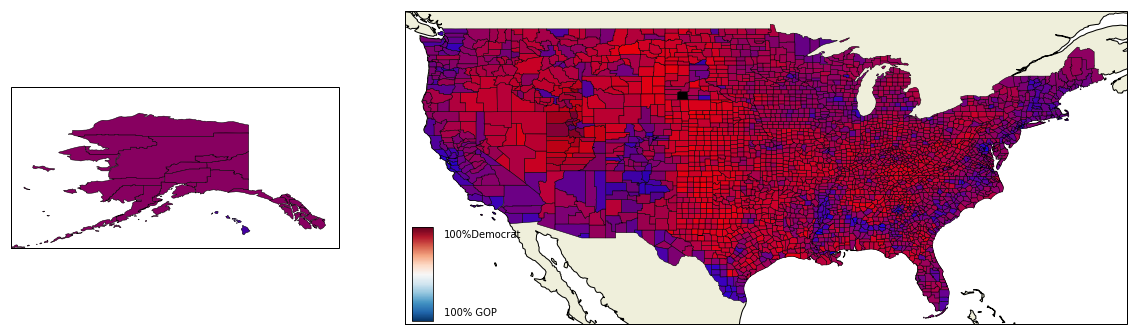

In [397]:
# Our first plot, looking at the difference between percentage DEM and GOP in each county
plot_heatmaps_by_count(df=county_level_final, records=records, save="pct_gop_dem")

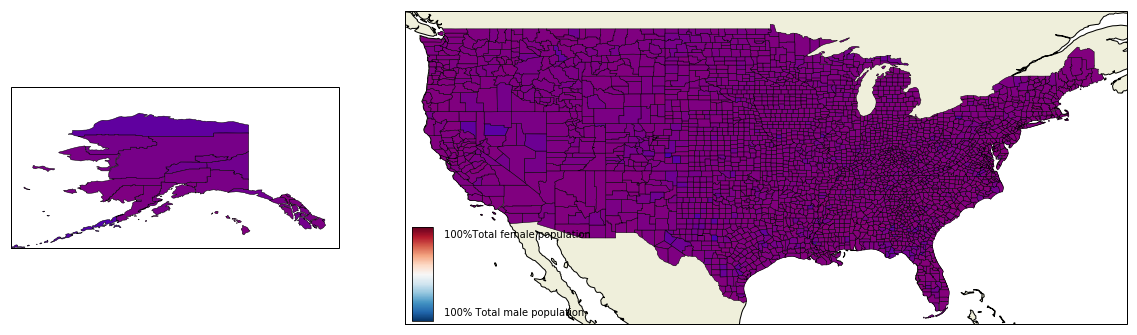

In [377]:
plot_df = population_and_vote_df.groupby(['combined_fips']).sum()
plot_df['SPREAD'] = (plot_df['votes_dem']-plot_df['votes_gop'])/plot_df['total_votes']
# plot_df['POP_DENSITY'] = plot_df['POP_DENSITY']/plot_df['POP_DENSITY'].max()
plot_heatmaps_by_count(df=plot_df, records=records, scale1='TOT_MALE', scale2='TOT_FEMALE', divisor='TOT_POP')

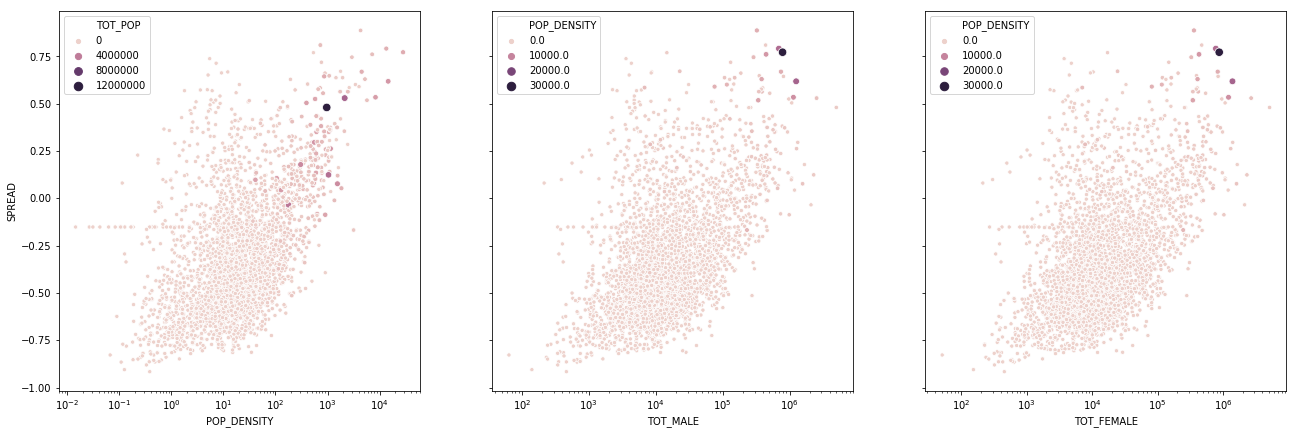

In [104]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 7), sharey=True)
for i in range(3):
    ax[i].set(xscale="log")
g0 = sns.scatterplot(x='POP_DENSITY', y='SPREAD', data=plot_df, size='TOT_POP', hue='TOT_POP', ax=ax[0])
g1 = sns.scatterplot(x='TOT_MALE', y='SPREAD', data=plot_df, size='POP_DENSITY', hue='POP_DENSITY', ax=ax[1])
g2 = sns.scatterplot(x='TOT_FEMALE', y='SPREAD', data=plot_df, size='POP_DENSITY', hue='POP_DENSITY', ax=ax[2])

In [105]:
plot_df[['SPREAD','POP_DENSITY']].describe()

,SPREAD,POP_DENSITY
count,3139.000000,3142.000000
mean,-0.317910,104.982551
std,0.307283,706.970288
min,-0.916364,0.014362
25%,-0.545159,6.476804
50%,-0.378583,17.265151
75%,-0.151697,44.939590
max,0.887245,28327.194534


In [107]:
# plot_df.head()
plot_df.columns

Index(['SUMLEV', 'STATE', 'COUNTY', 'YEAR', 'AGEGRP', 'TOT_POP', 'TOT_MALE',
       'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE',
       'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE',
       'TOM_FEMALE', 'WAC_MALE', 'WAC_FEMALE', 'BAC_MALE', 'BAC_FEMALE',
       'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE', 'AAC_FEMALE', 'NAC_MALE',
       'NAC_FEMALE', 'NH_MALE', 'NH_FEMALE', 'NHWA_MALE', 'NHWA_FEMALE',
       'NHBA_MALE', 'NHBA_FEMALE', 'NHIA_MALE', 'NHIA_FEMALE', 'NHAA_MALE',
       'NHAA_FEMALE', 'NHNA_MALE', 'NHNA_FEMALE', 'NHTOM_MALE', 'NHTOM_FEMALE',
       'NHWAC_MALE', 'NHWAC_FEMALE', 'NHBAC_MALE', 'NHBAC_FEMALE',
       'NHIAC_MALE', 'NHIAC_FEMALE', 'NHAAC_MALE', 'NHAAC_FEMALE',
       'NHNAC_MALE', 'NHNAC_FEMALE', 'H_MALE', 'H_FEMALE', 'HWA_MALE',
       'HWA_FEMALE', 'HBA_MALE', 'HBA_FEMALE', 'HIA_MALE', 'HIA_FEMALE',
       'HAA_MALE', 'HAA_FEMALE', 'HNA_MALE', 'HNA_FEMALE', 'HTOM_MALE',
       'HTOM_FEMALE', 'HWAC_MALE', 'HWAC

In [143]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn import cross_validation, metrics, model_selection
from sklearn.grid_search import GridSearchCV
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


In [500]:
plot_df_no_nan = plot_df[plot_df.isnull().any(axis=1)==False]
X = plot_df_no_nan.reset_index().drop(['combined_fips', 'SUMLEV', 'STATE', 'COUNTY', 'YEAR', 'AGEGRP', 'votes_dem', 'votes_gop', 'total_votes', 'per_dem', 'per_gop', 'SPREAD'], axis=1).astype(np.float32)
y = plot_df_no_nan['SPREAD'].values
y = y.reshape(-1,1)
y = y.astype(np.float32)
# If running a classifier, this needs to be mapped to a binary output
y = np.sign(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=47)

In [425]:
### Random Forrest Classification
seed = 47
num_trees = 10
max_features = 3
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X_train, y_train.ravel(), cv=kfold)
print("Mean estimate of classification accuracy: {}".format(results.mean()))

model.fit(X=X_train, y=y_train.ravel())
test_fit = model.predict(X=X_test)
test_results = [test_fit[i]==y_test[i] for i in range(len(y_test))]
print("Test results: {}/{} correct".format(np.sum(test_results), len(y_test)))

Mean estimate of classification accuracy: 0.9051224218730421
Test results: 289/314 correct


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


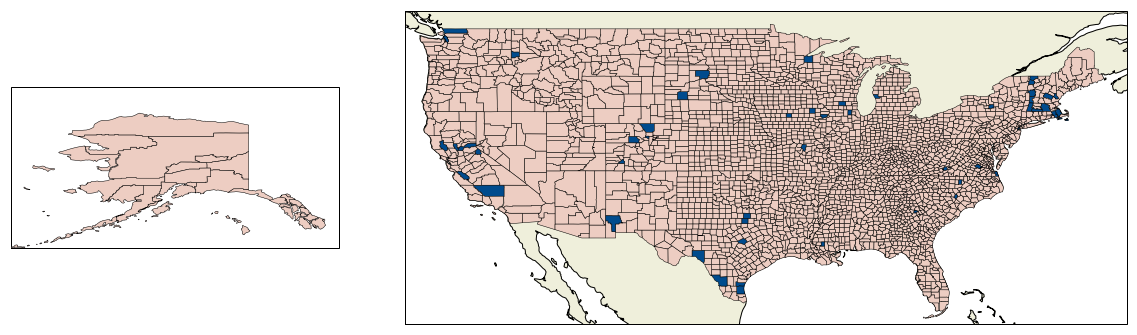

In [514]:
# Looking at correct (red) vs incorrect (black) predictions
predicted_binarized_spread = model.predict(X=X)
plot_df_random_forrest_results = plot_df[plot_df.isnull().any(axis=1)==False]
plot_df_random_forrest_results['SPREAD_BINARIZED'] = list(map(lambda x: (x+1)/2.0, np.sign(y.ravel())))
plot_df_random_forrest_results['SPREAD_BINARIZED_PREDICTED'] = list(map(lambda x: 1 if x==0 else 0, np.abs(predicted_binarized_spread-np.sign(y.ravel()))))
plot_heatmaps_by_count(df=plot_df_random_forrest_results,
                       records=records,
                       scale2='SPREAD_BINARIZED_PREDICTED',
                       legend=False,
                       save="RF_binary_classification",
                       color="#EDCDC2"
                      )

In [498]:
state_county_wrong = set()
states_wrong = set()
for s in plot_df_random_forrest_results[plot_df_random_forrest_results['SPREAD_BINARIZED_PREDICTED']==0]['STATE'].values:

    for state in set([x[0] for x in county_level_combined[county_level_combined['state_fips']==str(s)][['state_abbr']].values]):
        states_wrong.add(state)
    states_counties = [', '.join(x) for x in county_level_combined[county_level_combined['state_fips']==str(s)][['county_name', 'state_abbr']].values]
    for s_c in states_counties:
        state_county_wrong.add(state)
print("Incorrect classification for {} counties in total in \n{}".format(plot_df_random_forrest_results[plot_df_random_forrest_results['SPREAD_BINARIZED_PREDICTED']==0].shape[0],
                                                                      ", ".join(sorted(states_wrong))))

Incorrect classification for 54 counties in total in 
GA, IA, ID, IL, LA, MA, MI, MO, NC, NH, NM, NY, SD, TX, VA, VT, WA, WI


In [139]:


n_ests = 200
max_depth = 200
params = {'n_estimators': n_ests, 'max_depth': max_depth, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=200,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [140]:
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

pb = progressbar.ProgressBar(max_value=n_ests)
for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)
    pb.update(i+1)
pb.finish()

100% (200 of 200) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


MSE: 0.3602


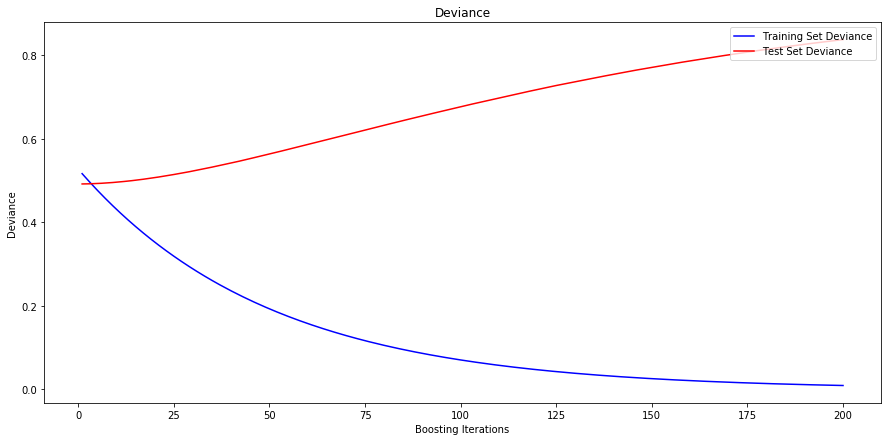

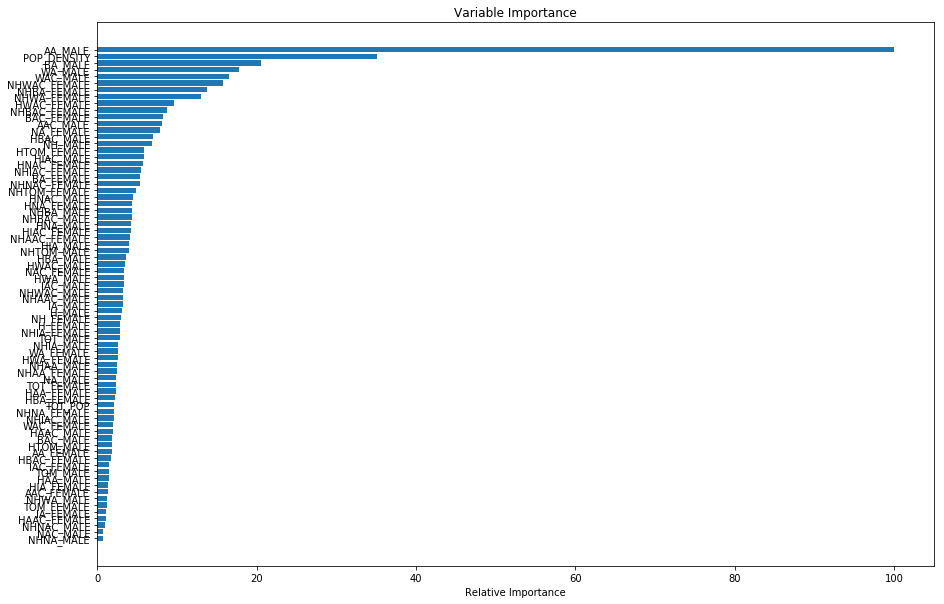

In [142]:
f, ax = plt.subplots(figsize=(15, 7))
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

f, ax = plt.subplots(figsize=(15, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [731]:
print("Top 5 predictors:\n")
for x in range(1,6):
    print("{}\t=== {}".format(X.columns[sorted_idx][-x], legend[X.columns[sorted_idx][-x]]))

Top 5 predictors:

AA_MALE	=== Asian alone male population
POP_DENSITY	=== Population Density
BA_MALE	=== Black or African American alone male population
NHWAC_FEMALE	=== Not Hispanic, White alone or in combination female population
WA_MALE	=== White alone male population


In [726]:
label_encoded_y = LabelEncoder().fit_transform(np.sign(y).ravel())
model = XGBClassifier()
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(subsample=subsample)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [727]:
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold.split(X_train, y_train))
grid_result = grid_search.fit(X, label_encoded_y)

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
plt.errorbar(subsample, means, yerr=stds)
plt.title("XGBoost subsample vs Log Loss")
plt.xlabel('subsample')
plt.ylabel('Log Loss')
